In [1]:
import sys
sys.path.insert(0, '/tf/utils/')

In [2]:
base_shape_size = 8192
ws = 255
ol = 128
input_shape = (128, 64, 1)

In [3]:
from utils import calculate_stft_magnitude_and_phase, reconstruct_signal_from_stft
from sound import Sound
from data_generators import NoisyTargetGenerator, NoisyTargetDoubleGenerator
from artigos.DeepNoiseSuppressionWithNonIntrusivePESQNet import DeepNoiseSuppressionWithNonIntrusivePESQNet
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Audio
from IPython import display
import librosa

In [4]:
sound_base_train = Sound('/tf/Dados/Vozes/train/', '/tf/Dados/Ruido/train/', base_shape_size)
sound_base_val = Sound('/tf/Dados/Vozes/val/', '/tf/Dados/Ruido/val/', base_shape_size)

Loading Speech Files: 100%|██████████| 5725/5725 [01:33<00:00, 61.46it/s] 
/tf/utils/sound.py:62: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  clean_sounds = [sound for sound in clean_sounds if sound != self.TOO_SHORT_ERROR]
/tf/utils/sound.py:74: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  noise_sounds = [sound for sound in noise_sounds if sound != self.TOO_SHORT_ERROR]
Loading Speech Files: 100%|██████████| 1635/1635 [00:10<00:00, 155.18it/s] 


In [5]:
data_generator_train = NoisyTargetGenerator(sound_base_train.clean_sounds, sound_base_train.noise_sounds)
data_generator_val = NoisyTargetGenerator(sound_base_val.clean_sounds, sound_base_val.noise_sounds)

In [6]:
models_class = DeepNoiseSuppressionWithNonIntrusivePESQNet(input_shape, channels=1)

In [7]:
input_module = Input(shape=input_shape)

module_output = models_class.DNSModel(input_module)
# dns_module = models_class.DNSModel(dns_module)
# dns_module = models_class.DNSModel(dns_module)
# module_output = models_class.DNSModel(dns_module)

model = Model(inputs=input_module, outputs=module_output)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 64, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 64, 1)  4           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 128, 64, 64)  1664        ['batch_normalization[0][0]']    
                                                                                              

In [9]:
class GenerateImagesCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_val, y_val):
        self.x_val = x_val
        self.y_val = y_val

    def on_epoch_end(self, epoch, logs=None):
        indice_aleatorio = np.random.choice(self.x_val.shape[0])
        amostra_noisy_module = self.x_val[indice_aleatorio][np.newaxis, ...]
        amostra_original_module = self.y_val[indice_aleatorio][np.newaxis, ...]
        generate_images(self.model, amostra_noisy_module, amostra_original_module)

In [10]:
class PlotLossesCallback(tf.keras.callbacks.Callback):
    def __init__(self, plot_freq):
        super(PlotLossesCallback, self).__init__()
        self.plot_freq = plot_freq
        self.losses = []
        self.fig, self.ax = None, None

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss:
            self.losses.append(loss)
            if (batch + 1) % self.plot_freq == 0:
                self.plot_losses(batch)

    def plot_losses(self, batch):
        if self.fig == None and self.ax == None:
            self.fig, self.ax = plt.subplots(figsize=(10, 4))
        self.ax.clear()
        self.ax.plot(self.losses, '-o')  # Linha com marcadores circulares

        # Adicionando um data label para o último ponto
        if self.losses:
            last_loss = self.losses[-1]
            self.ax.text(len(self.losses) - 1, last_loss, f'{last_loss:.4f}', fontsize=9, verticalalignment='bottom')

        self.ax.set_title(f"Losses up to batch {batch+1}")
        self.ax.set_xlabel("Batch")
        self.ax.set_ylabel("Loss")
        self.fig.canvas.draw()

In [11]:
# Gera um novo lote de validação para cada época
validation_batch = next(data_generator_val.generate_sample_completo(batch_size=32, only_return_mudule=True))
x_val, y_val = validation_batch

In [12]:
print(np.min(x_val))
print(np.min(y_val))

0.00031202947
7.1013496e-06


In [13]:
steps_per_epoch_train = len(sound_base_train.clean_sounds)
steps_per_epoch_validation = len(sound_base_val.clean_sounds)

In [14]:
best_models_path = "./DNS_checkpoints/"
callbacks_lst = [
    tf.keras.callbacks.ModelCheckpoint(filepath=best_models_path+"best_DNS_128x64.h5", save_freq=100, save_weights_only=False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=0.0000009, min_delta=0.0001, factor=0.70, patience=4, verbose=1, mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, min_delta=0.0001, patience=14),
    GenerateImagesCallback(x_val, y_val),
    PlotLossesCallback(plot_freq=20)
]

In [15]:
def weighted_msle(y_true, y_pred):
    # Define o peso para penalizar mais as subestimações
    w = 2.0

    # Evita valores negativos adicionando 1 antes de aplicar o log
    log_true = 20 * tf.math.log(y_true + 1)
    log_pred = 20 * tf.math.log(y_pred + 1)

    # Cálculo do erro
    error = log_true - log_pred

    # Aplica pesos diferentes para superestimação e subestimação
    weighted_error = tf.where(error > 0, w * error, error)

    # Retorna a média do erro logarítmico quadrado ponderado
    return tf.reduce_mean(tf.abs(weighted_error))

In [16]:
# Compile o modelo com sua escolha de otimizador e função de perda
# model.compile(optimizer='adam', loss='mse')
model.compile(loss='mse', optimizer=Adam(learning_rate=0.0009))
# Resumo do Modelo
# model.summary()

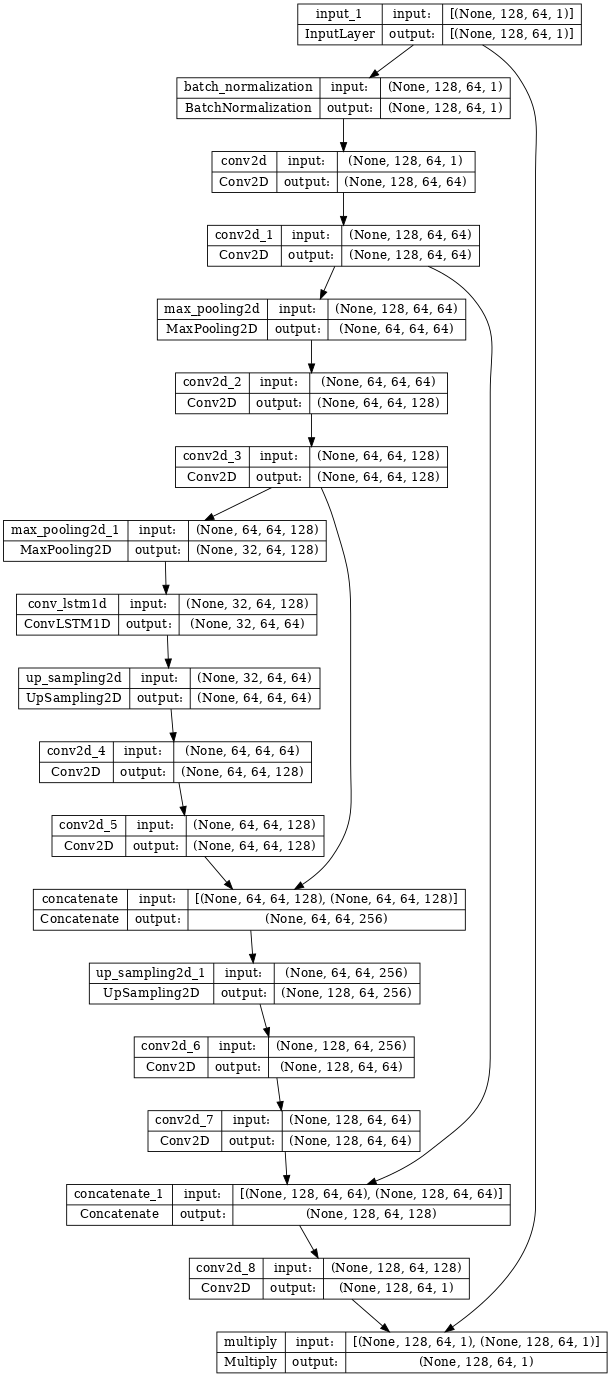

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [18]:
def generate_images(model, test_input, tar):
    
    prediction = model(test_input, training=True)
    plt.figure(figsize=(22, 7))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Log Power Spectrum - Som ruidoso', 'Log Power Spectrum - Som original', 'Log Power Spectrum - Som filtrado']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(10 * np.log10((display_list[i][..., 0])**2), aspect='auto', cmap='inferno')
        plt.colorbar(format='%+2.0f dB')  # Removi a variável 'im' e 'axs[0]'
        plt.axis('off')
    
    plt.show()

Epoch 1/100
876/876 [==============================] - ETA: 0s - loss: 0.1338

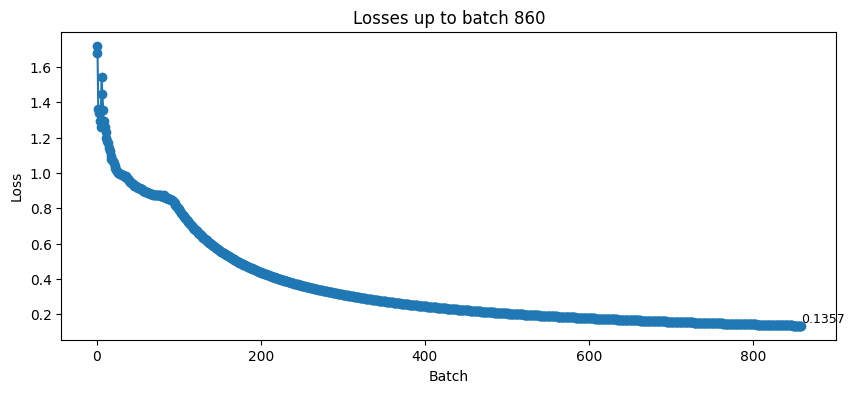

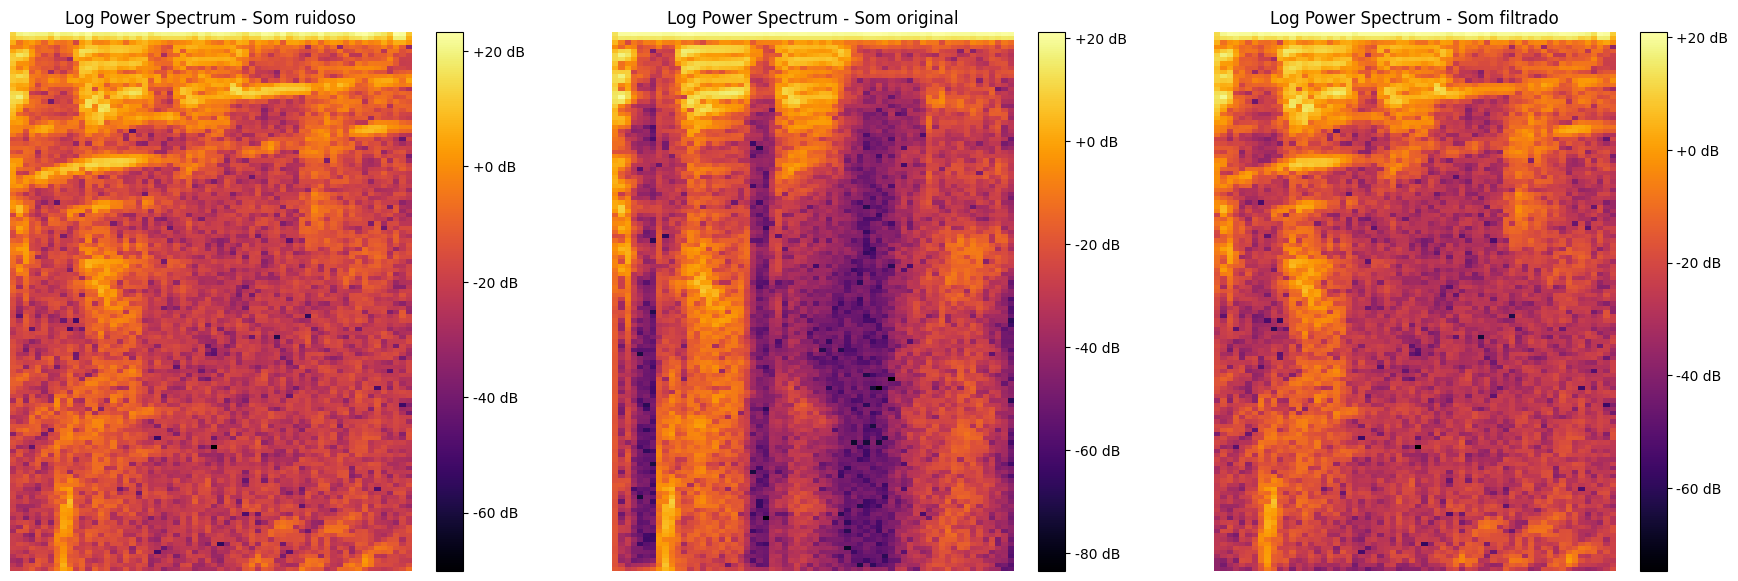

876/876 [==============================] - 501s 552ms/step - loss: 0.1338 - val_loss: 0.0385 - lr: 9.0000e-04
Epoch 2/100
876/876 [==============================] - ETA: 0s - loss: 0.0310

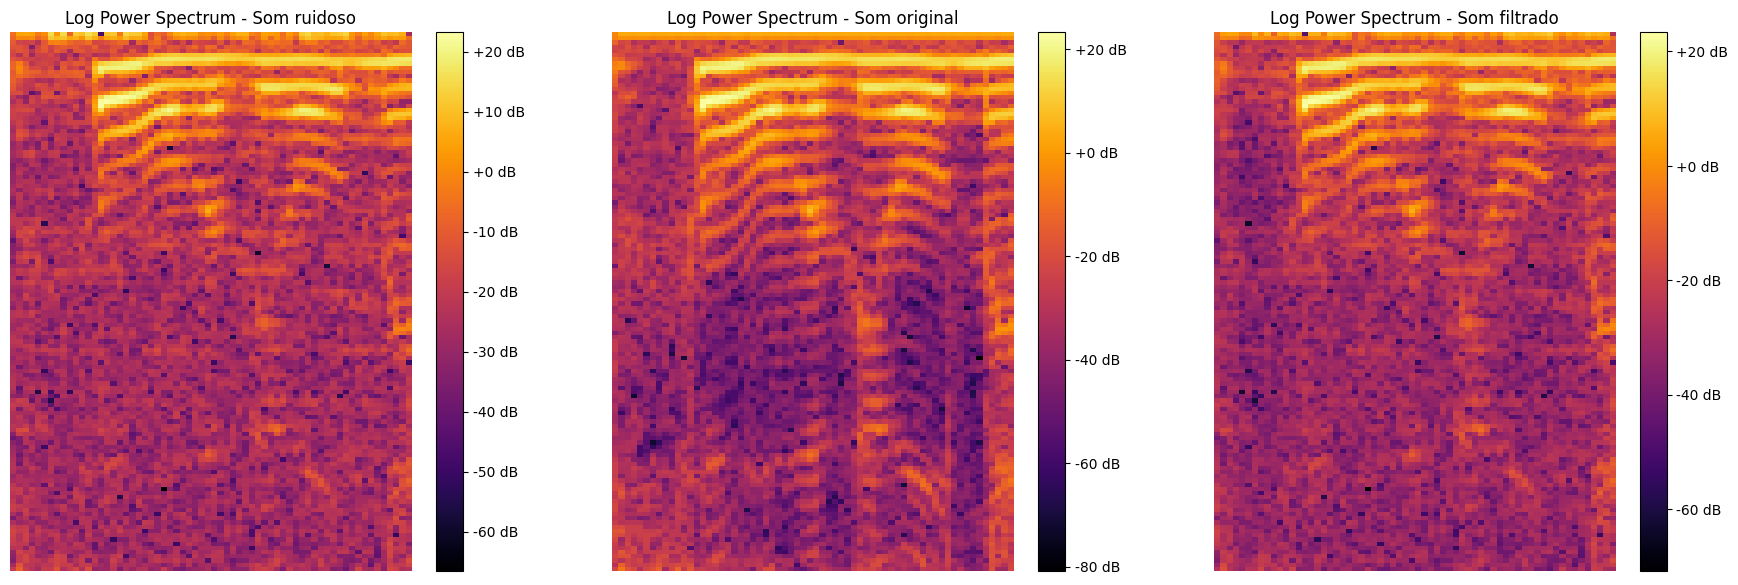

876/876 [==============================] - 485s 554ms/step - loss: 0.0310 - val_loss: 0.0296 - lr: 9.0000e-04
Epoch 3/100
876/876 [==============================] - ETA: 0s - loss: 0.0268

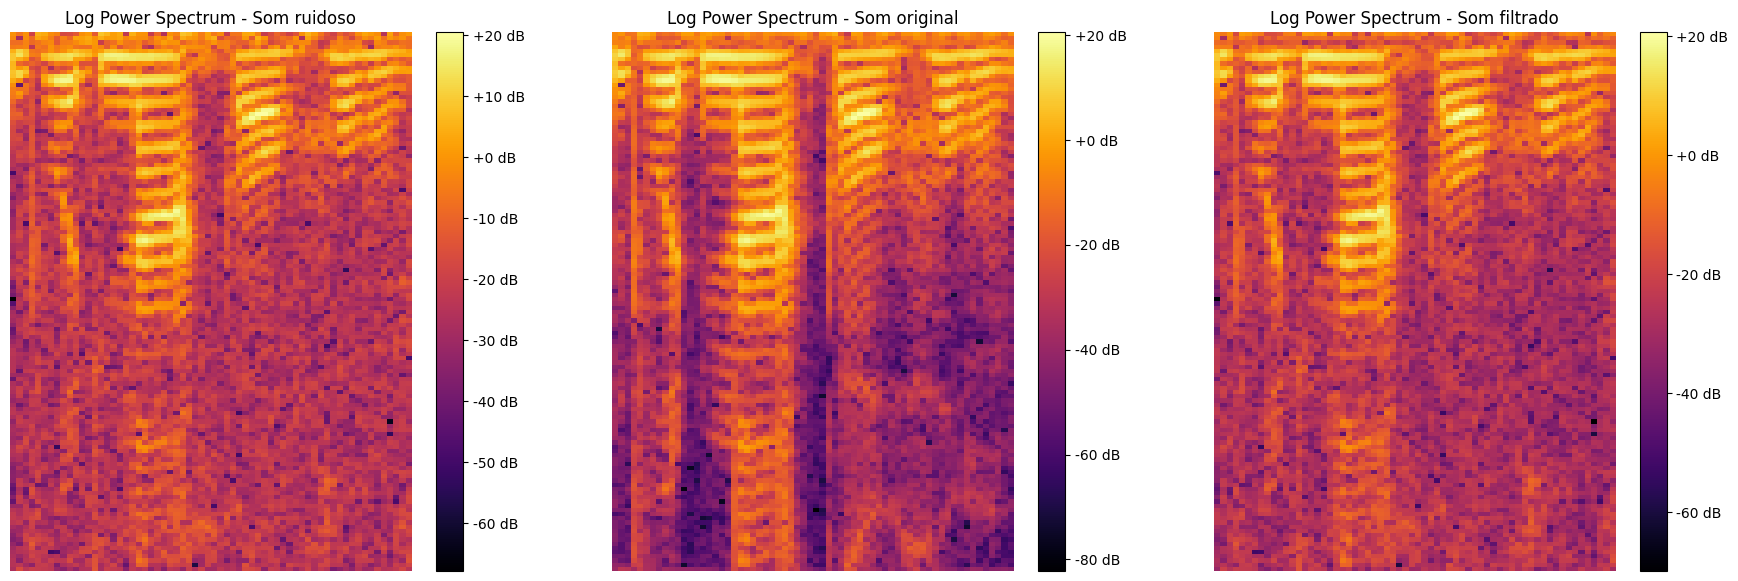

876/876 [==============================] - 485s 554ms/step - loss: 0.0268 - val_loss: 0.0255 - lr: 9.0000e-04
Epoch 4/100
876/876 [==============================] - ETA: 0s - loss: 0.0239

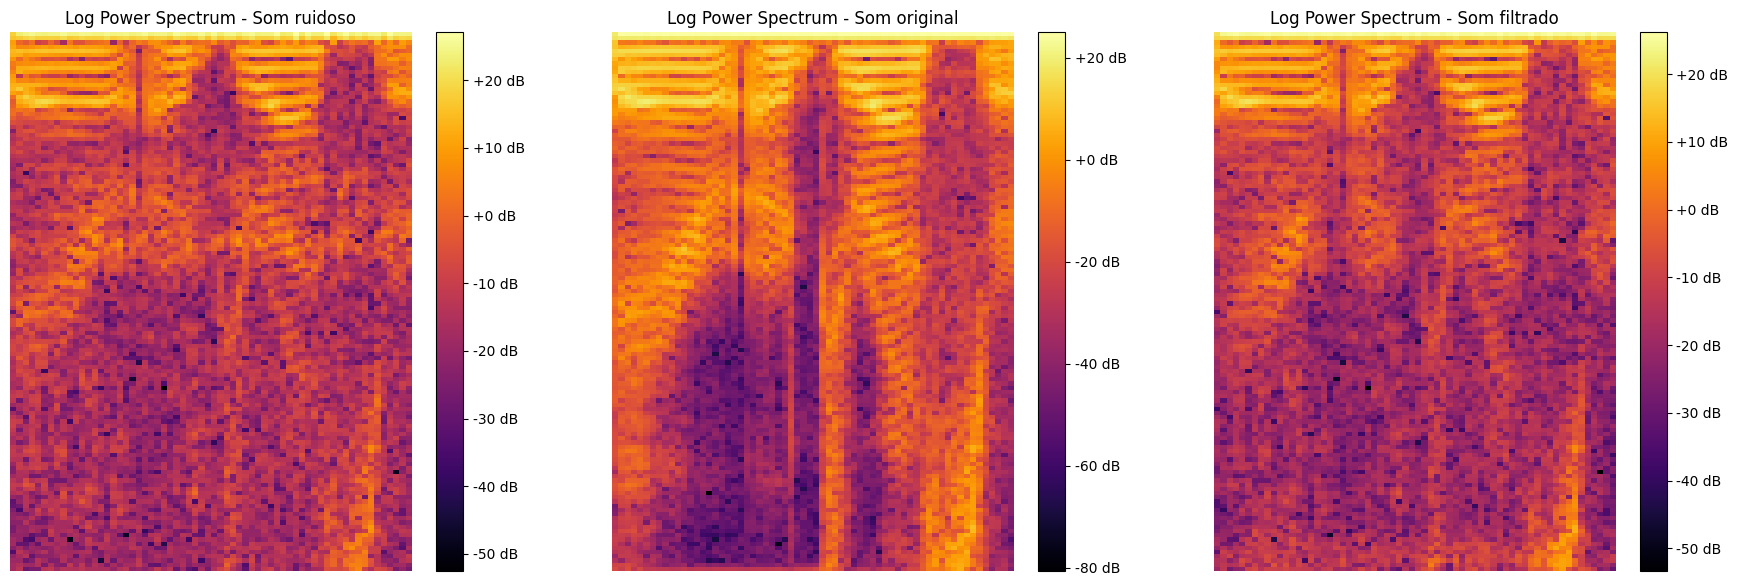

876/876 [==============================] - 486s 555ms/step - loss: 0.0239 - val_loss: 0.0422 - lr: 9.0000e-04
Epoch 5/100
876/876 [==============================] - ETA: 0s - loss: 0.0229

/tmp/ipykernel_8154/2126619554.py:13: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(10 * np.log10((display_list[i][..., 0])**2), aspect='auto', cmap='inferno')


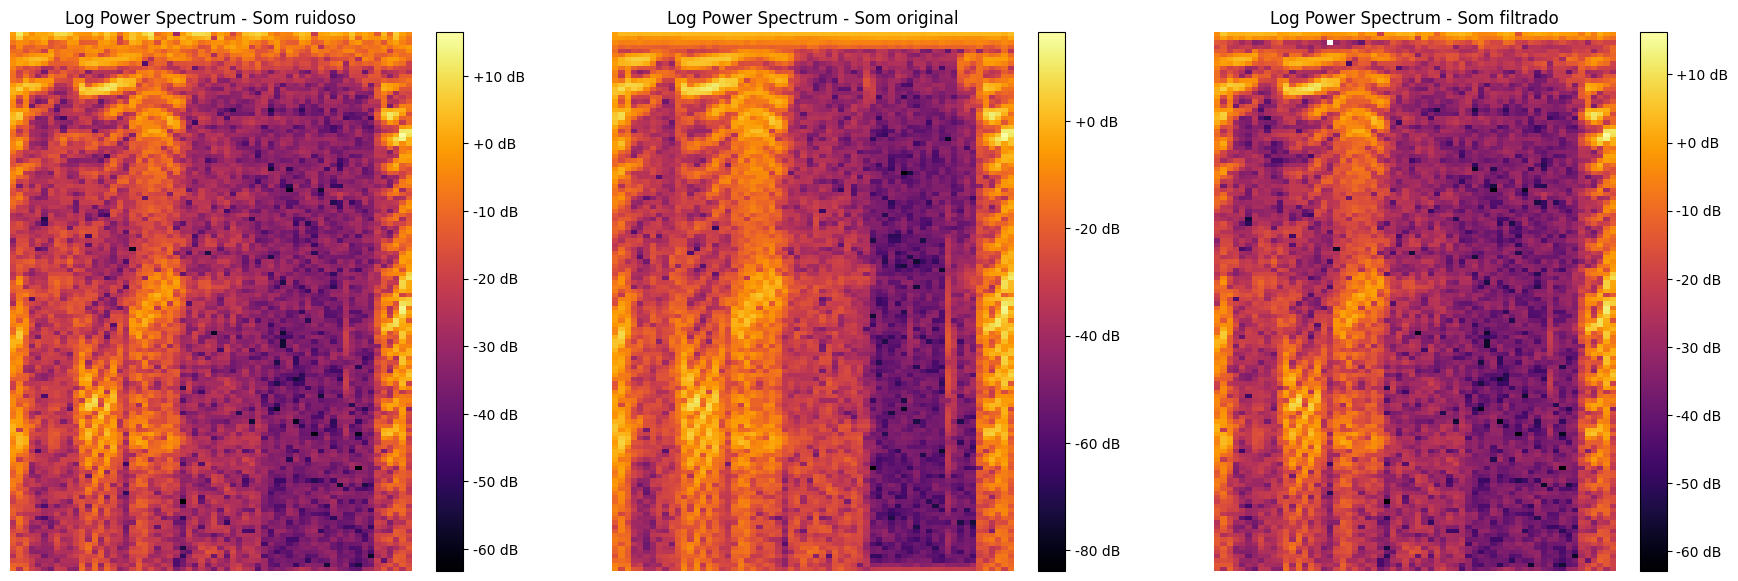

876/876 [==============================] - 486s 555ms/step - loss: 0.0229 - val_loss: 0.0242 - lr: 9.0000e-04
Epoch 6/100
876/876 [==============================] - ETA: 0s - loss: 0.0210

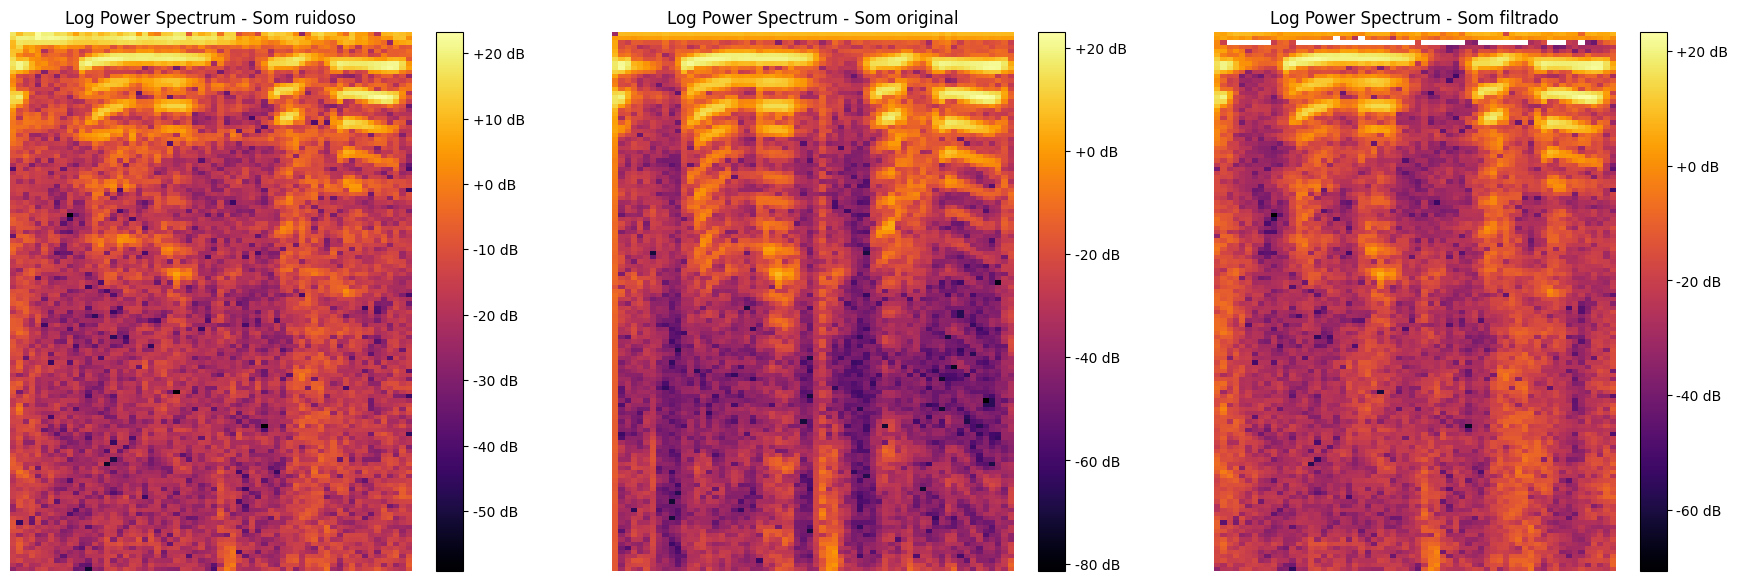

876/876 [==============================] - 486s 555ms/step - loss: 0.0210 - val_loss: 0.0215 - lr: 9.0000e-04
Epoch 7/100
876/876 [==============================] - ETA: 0s - loss: 0.0192

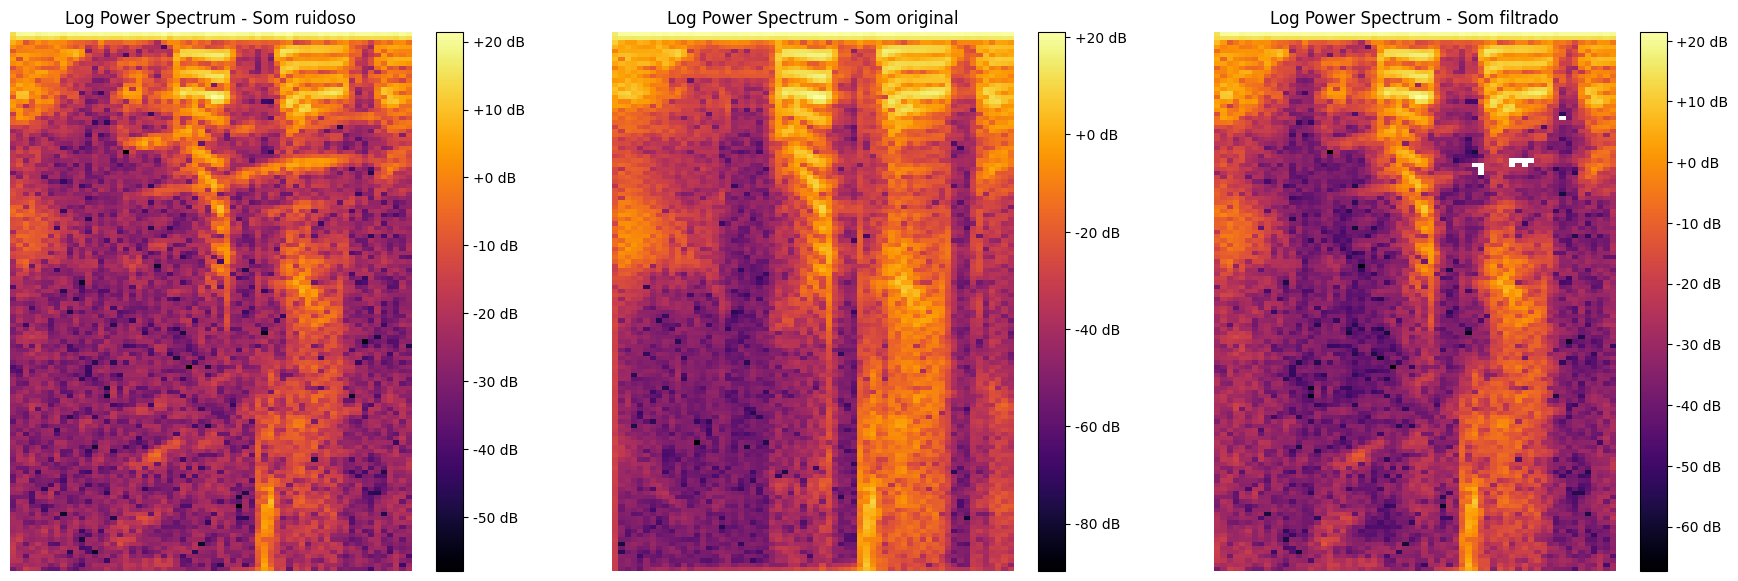

876/876 [==============================] - 485s 554ms/step - loss: 0.0192 - val_loss: 0.0212 - lr: 9.0000e-04
Epoch 8/100
876/876 [==============================] - ETA: 0s - loss: 0.0195

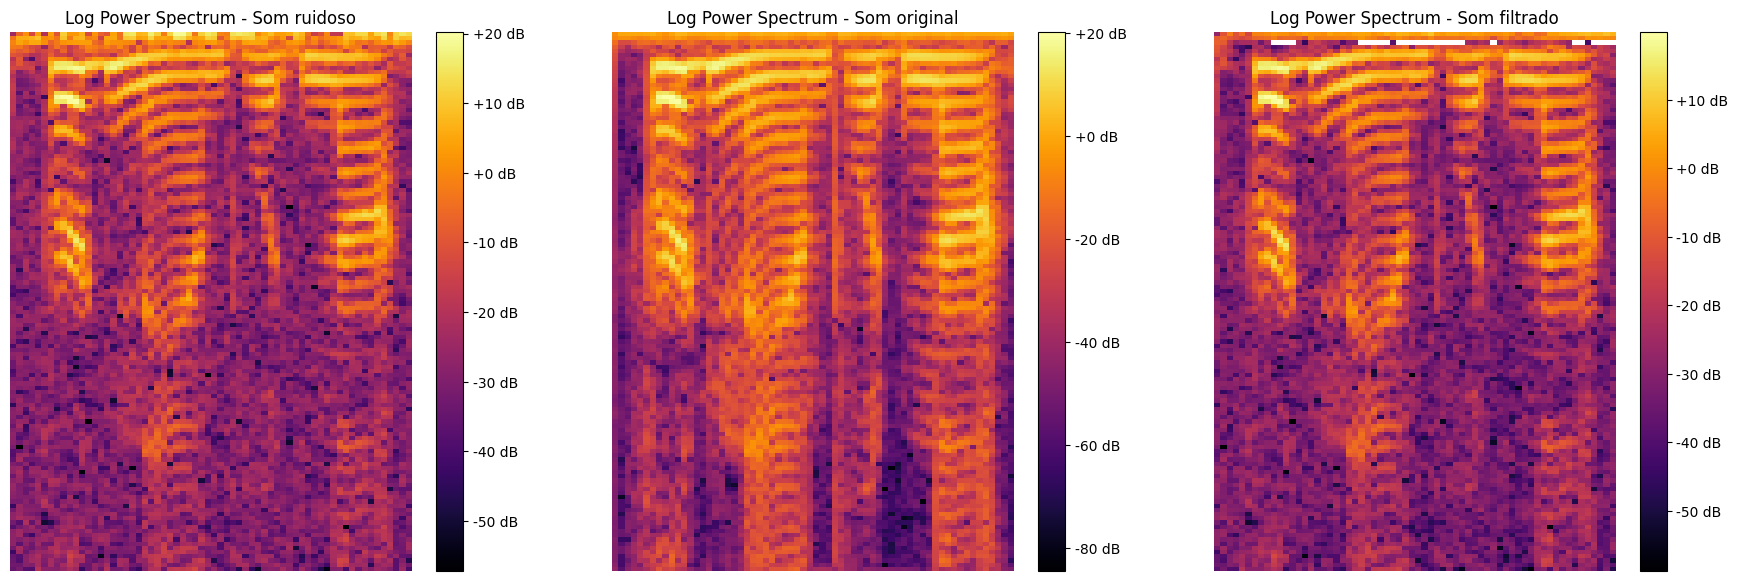

876/876 [==============================] - 486s 555ms/step - loss: 0.0195 - val_loss: 0.0182 - lr: 9.0000e-04
Epoch 9/100
876/876 [==============================] - ETA: 0s - loss: 0.0185

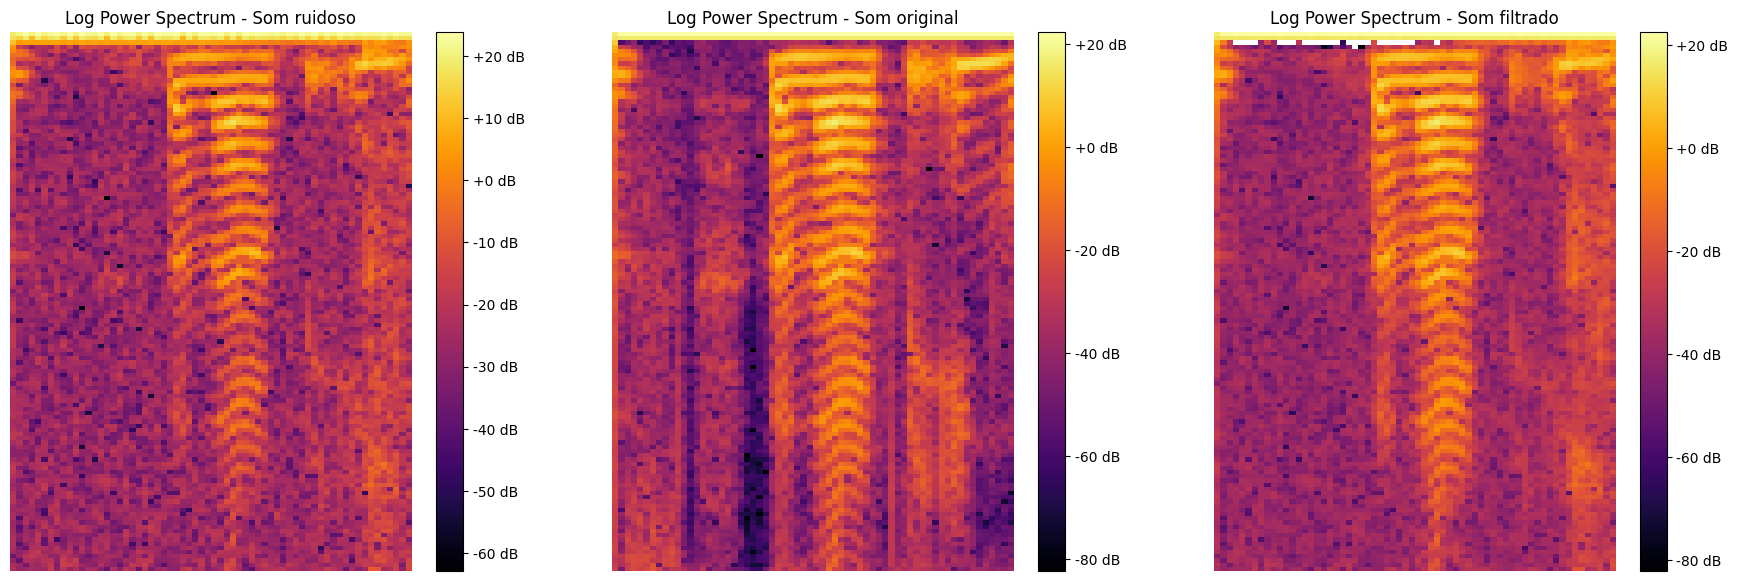

876/876 [==============================] - 486s 555ms/step - loss: 0.0185 - val_loss: 0.0180 - lr: 9.0000e-04
Epoch 10/100
876/876 [==============================] - ETA: 0s - loss: 0.0177

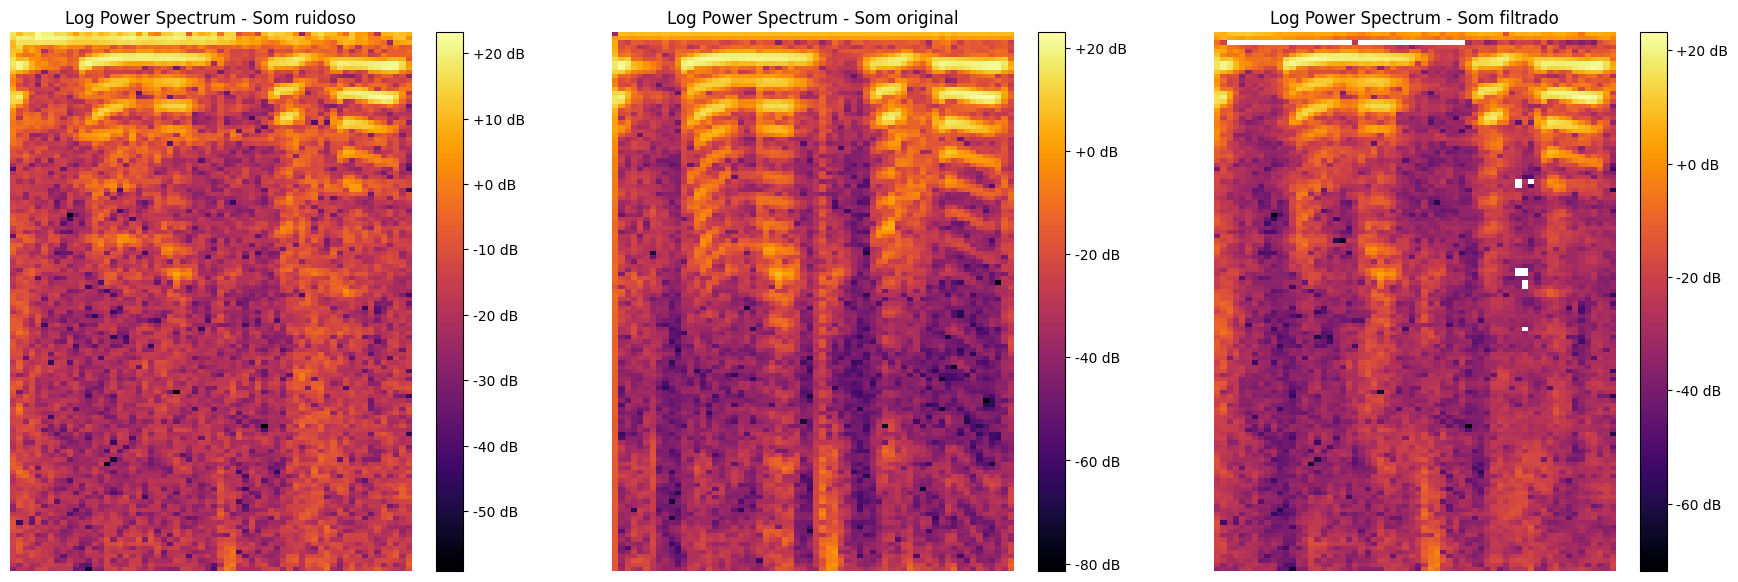

876/876 [==============================] - 486s 555ms/step - loss: 0.0177 - val_loss: 0.0199 - lr: 9.0000e-04
Epoch 11/100
876/876 [==============================] - ETA: 0s - loss: 0.0168

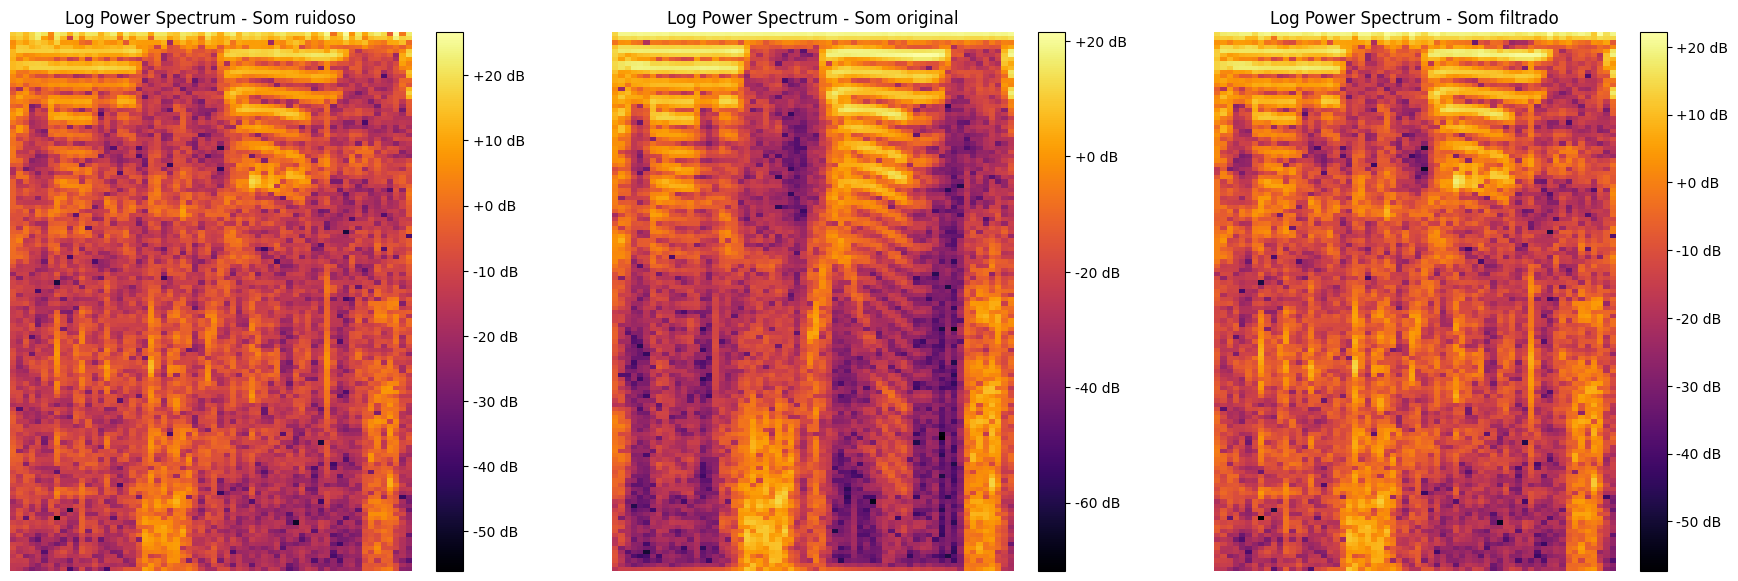

876/876 [==============================] - 486s 555ms/step - loss: 0.0168 - val_loss: 0.0170 - lr: 9.0000e-04
Epoch 12/100
876/876 [==============================] - ETA: 0s - loss: 0.0179

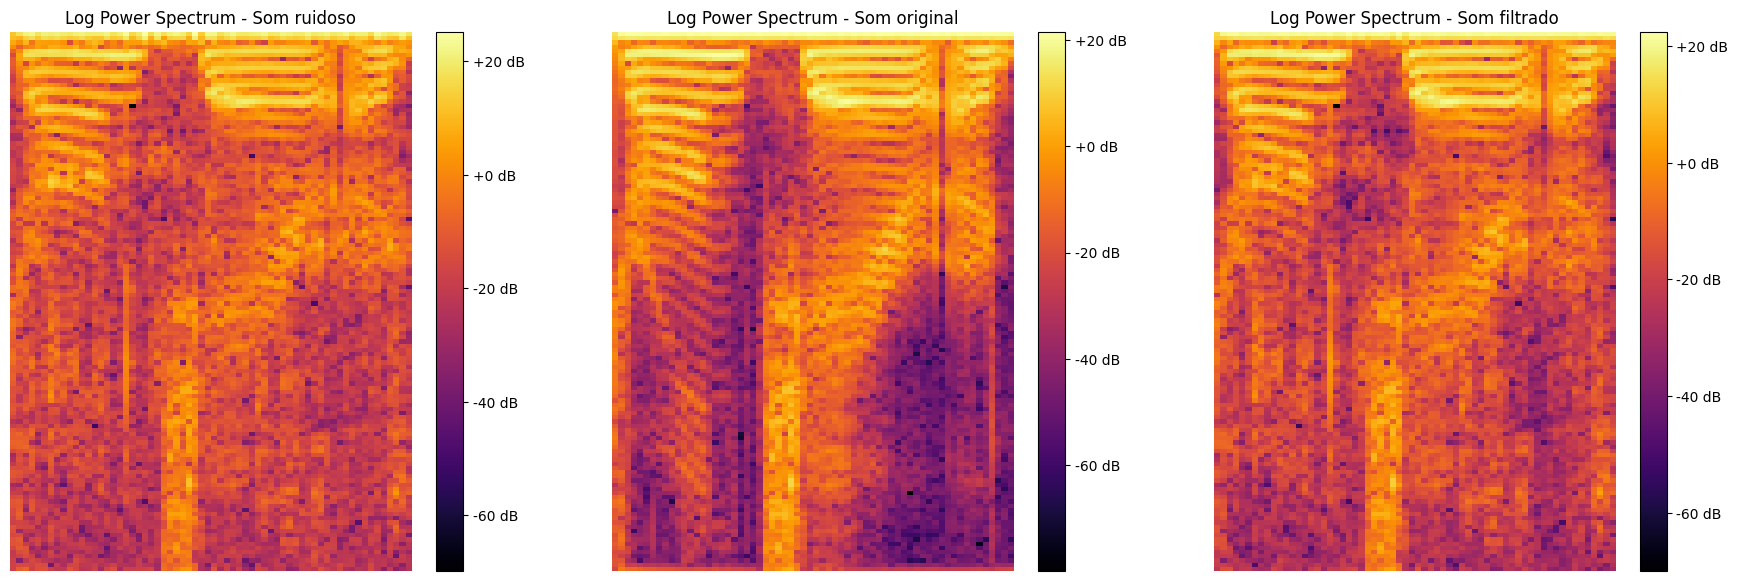

876/876 [==============================] - 486s 555ms/step - loss: 0.0179 - val_loss: 0.0167 - lr: 9.0000e-04
Epoch 13/100
876/876 [==============================] - ETA: 0s - loss: 0.0165

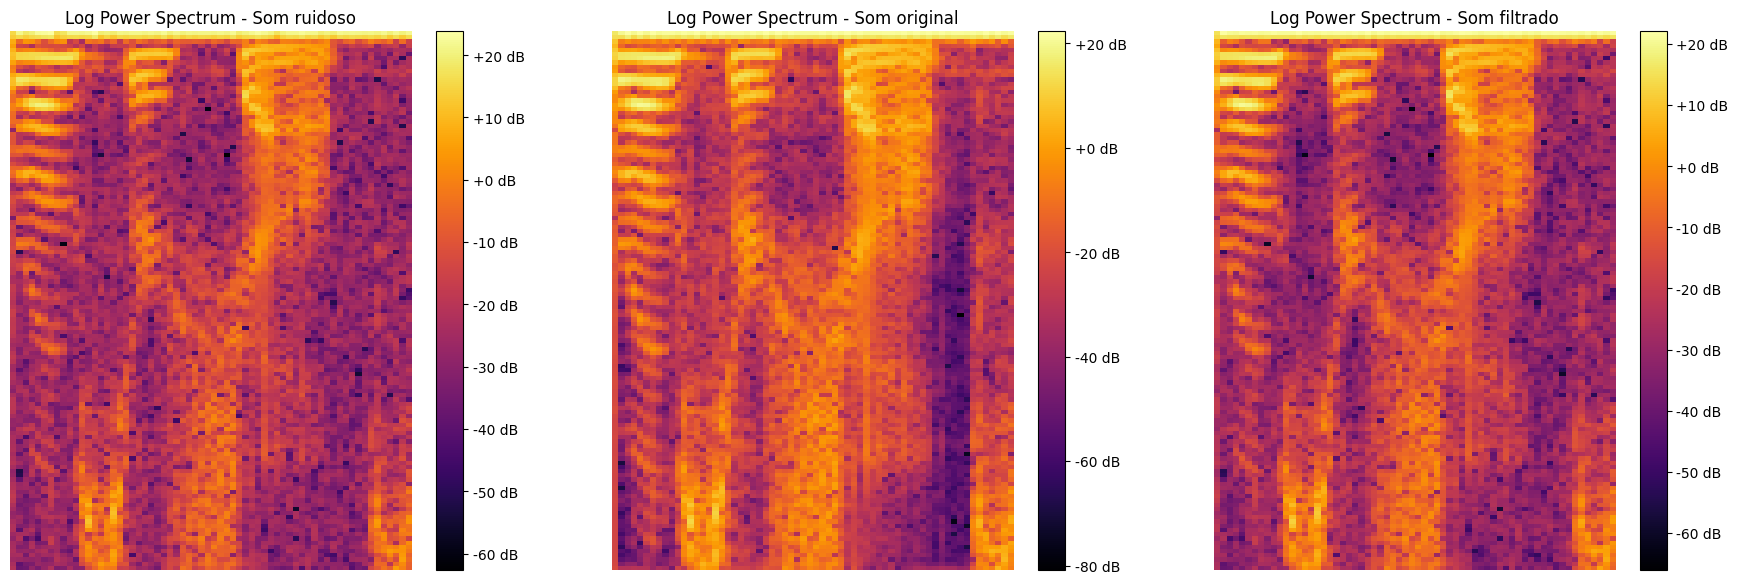

876/876 [==============================] - 487s 556ms/step - loss: 0.0165 - val_loss: 0.0154 - lr: 9.0000e-04
Epoch 14/100
876/876 [==============================] - ETA: 0s - loss: 0.0152

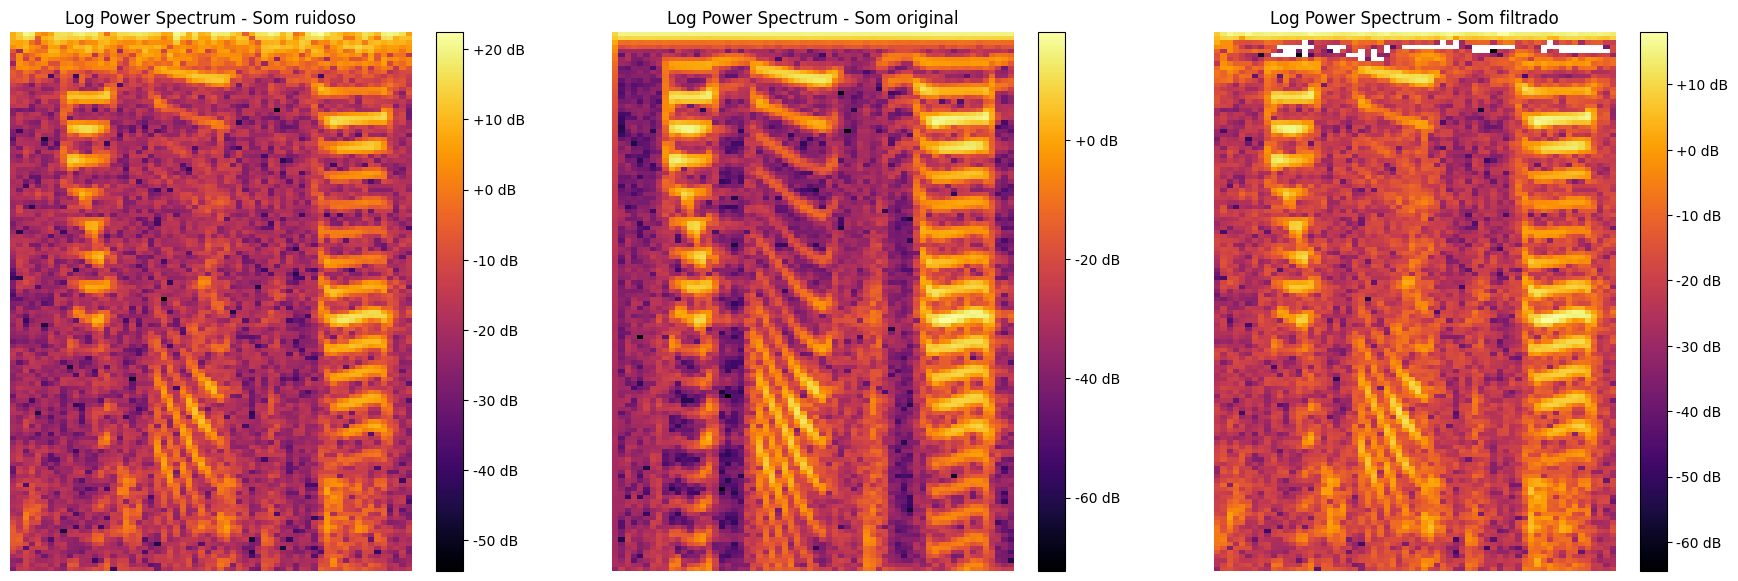

876/876 [==============================] - 487s 555ms/step - loss: 0.0152 - val_loss: 0.0166 - lr: 9.0000e-04
Epoch 15/100
876/876 [==============================] - ETA: 0s - loss: 0.0143

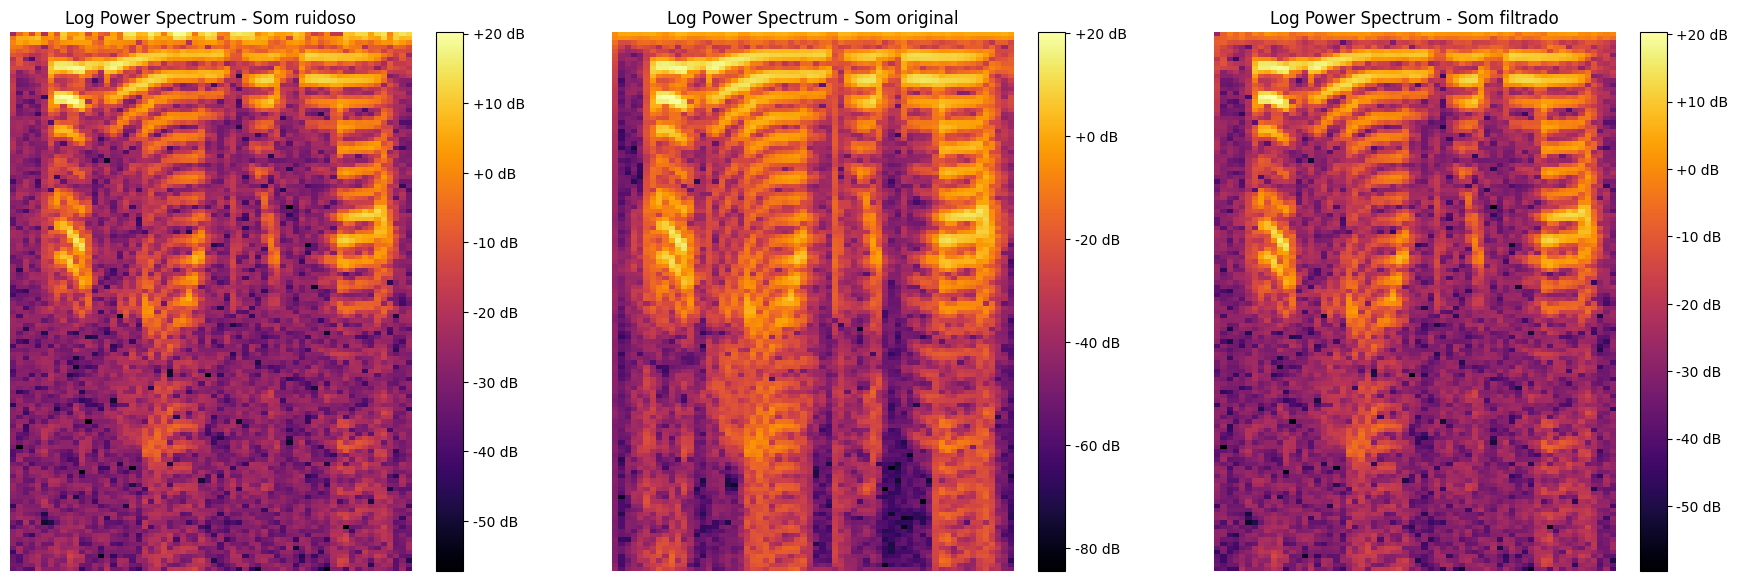

876/876 [==============================] - 486s 554ms/step - loss: 0.0143 - val_loss: 0.0158 - lr: 9.0000e-04
Epoch 16/100
876/876 [==============================] - ETA: 0s - loss: 0.0147

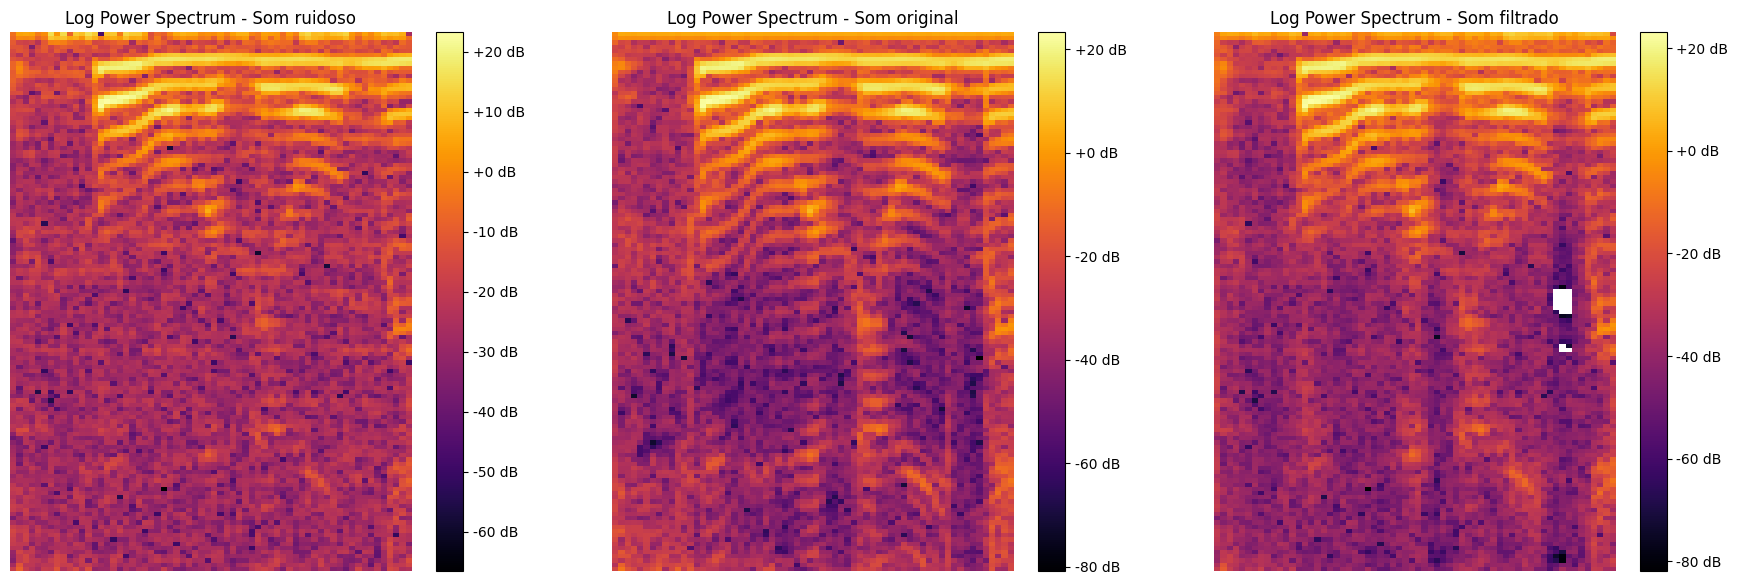

876/876 [==============================] - 486s 555ms/step - loss: 0.0147 - val_loss: 0.0182 - lr: 9.0000e-04
Epoch 17/100
876/876 [==============================] - ETA: 0s - loss: 0.0144

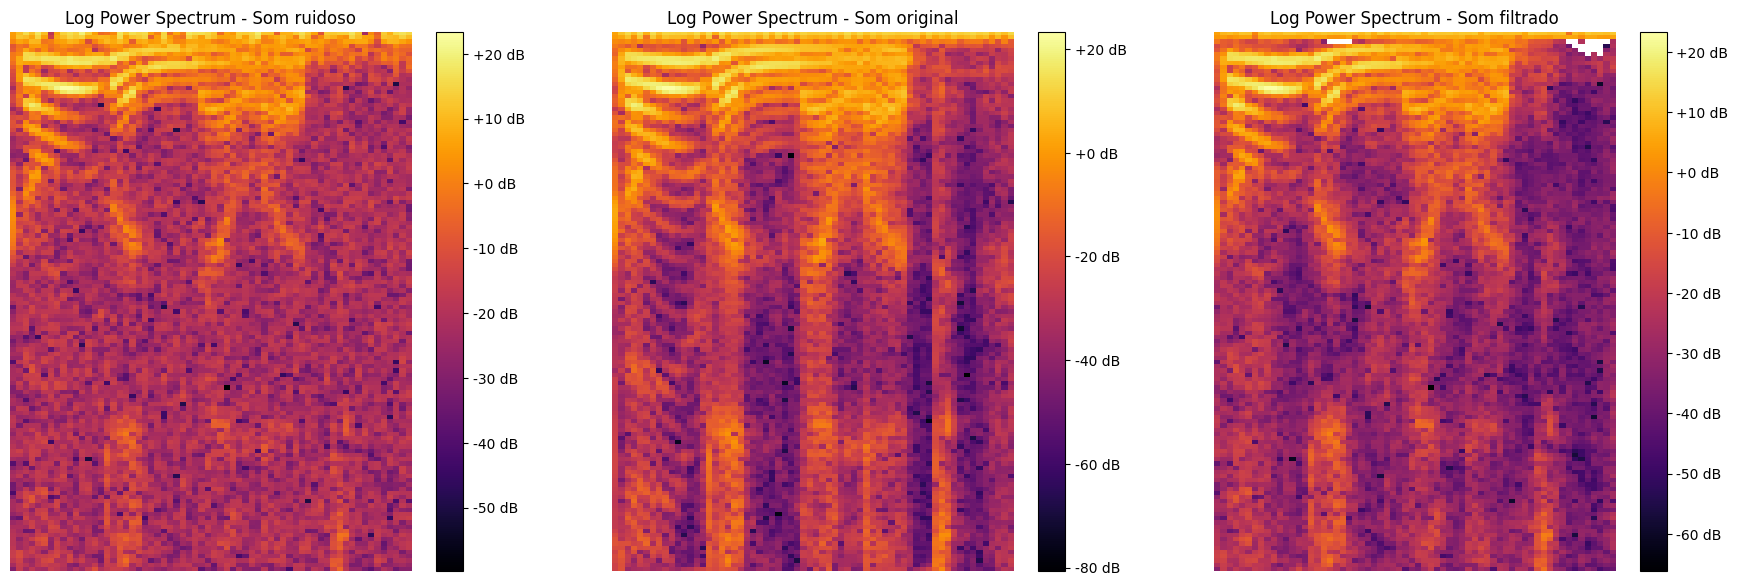

876/876 [==============================] - 486s 555ms/step - loss: 0.0144 - val_loss: 0.0147 - lr: 9.0000e-04
Epoch 18/100
608/876 [===================>..........] - ETA: 2:28 - loss: 0.0138

KeyboardInterrupt: 

In [19]:
batch_size = 32
steps_per_epoch = len(sound_base_train.clean_sounds) // batch_size
epochs = 100

val_data = next(data_generator_val.generate_sample_completo(batch_size=4 * batch_size, include_clean=True, only_return_mudule=True))

model.fit(data_generator_train.generate_sample_completo(batch_size=batch_size, include_clean=True, only_return_mudule=True),
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=val_data,
          callbacks=callbacks_lst
         )

In [20]:
x_test, y_test = next(data_generator_train.generate_sample_completo(batch_size=8))
F_f = model.predict(x_test[..., 0].reshape(*x_test[..., 0].shape, 1))

1/1 [==============================] - 1s 966ms/step


In [21]:
F_f.shape

(8, 128, 64, 1)

In [22]:
# x_test = x_test[0]
# y_test = y_test[0]
# F_f = F_f[0]

A = y_test[0][:, :,0]
phi = (y_test[0][:, :,1] - 0.5) * 2 * np.pi

A_n = x_test[0][:, :, 0]
phi_n = (x_test[0][:, :, 1] - 0.5) * 2 * np.pi

A_f = F_f[0][:, :,0]
phi_f = phi_n
# phi_f = (F_f[0][:, :, 1] - 0.5) * 2 * np.pi

s = reconstruct_signal_from_stft(A, phi)
s_n = reconstruct_signal_from_stft(A_n, phi_n)
s_f = reconstruct_signal_from_stft(A_f, phi_f)

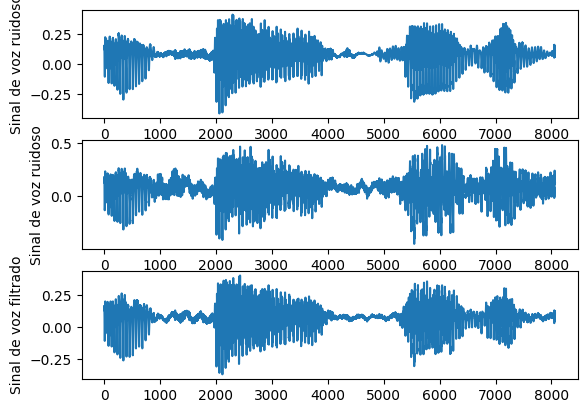

In [23]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plotando o primeiro array
ax1.plot(s)
ax1.set_ylabel('Sinal de voz ruidoso')

# Plotando o primeiro array
ax2.plot(s_n)
ax2.set_ylabel('Sinal de voz ruidoso')

ax3.plot(s_f)
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

In [24]:
Audio(data=s, rate=8000)

In [25]:
Audio(data=s_n, rate=8000)

In [26]:
Audio(data=s_f, rate=8000)

In [27]:
import datetime
# Get the current datetime
current_datetime = datetime.datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

model.save('DNS-loss-0.137-epochs-18-'+datetime_str+'.h5')